# Comparison of All Models - Backtesting, Vizualization

This notebook compares all internal models, as well as the standard formula approach. The comparison will be done with the implemented backtesting in mind. 

Additional plots, and vizualizations might be presented.

# Lage innholdsfortegnelse

In [1]:
from internal_models.historical_simulation.historical_simulation import HistoricalSimulation
from internal_models.montecarlo.mc_copula import MonteCarloCopula
from internal_models.montecarlo.mc_vanillagbm import MonteCarloVanillaGBM
from internal_models.montecarlo.mc_jumpgbm import MonteCarloJumpGBM
from backtesting.var_tests.christoffersens_test import christoffersen_independence_test
from backtesting.var_tests.kupiec_test import kupiec_pof_test
from internal_models.GANs.tuned_GANS import solveig_GAN, astrid_GAN, willow_GAN
from utilities.bof_var_plot import plot_bof_var
from utilities.model_saving import save_results, is_results_empty, load_results
from utilities.bof_var_plot import plot_bof_var
from utilities.gan_plotting import extensive_plotting

import pandas as pd
from tqdm import tqdm
import numpy as np
from dotenv.main import load_dotenv
load_dotenv(override=True)
import os

### Fixing the data. Splitting the data in a testing period.

Split date is set inside environment file.

In [2]:
def fetch_data_df():
    # Load the data
    df = pd.read_csv('data/final_daily_returns_asset_classes.csv', index_col=0, parse_dates=True)
    df.index = pd.to_datetime(df.index)
    start_test_date = os.getenv("START_TEST_DATE")
    
    if start_test_date is None:
        raise ValueError("Environment variable 'START_TEST_DATE' is not set.")

    start_test_date = pd.to_datetime(start_test_date)
    
    pre_test_df = df[df.index < start_test_date]
    test_df = df[df.index >= start_test_date].iloc[:252]
    
    return pre_test_df, test_df

returns_df, test_returns_df = fetch_data_df()

### Deciding on weights for portfolio

**ATTENTION:** Assuming an equally weighted portfolio for now

In [3]:
num_assets = returns_df.shape[1]
weights = np.full(num_assets, 1 / num_assets)  

### Other Parameters

In [4]:
assets_0 = int(os.getenv("INIT_ASSETS"))
liabilities_0 = int(os.getenv("INIT_ASSETS")) * float(os.getenv("FRAC_LIABILITIES"))
num_simulations = int(os.getenv("N_SIMULATIONS"))
bof_0 = assets_0 - liabilities_0

## Calculating SCR with common Internal Models

I.e the following models:

- Historical Simulation
- Monte Carlo simulations with Copulas (Student t's)
- Monte Carlo, vanilla GBM. No correlations between assets assumed
- Monte Carlo, GBM with jumps and correlations between assets

In [5]:
hs = HistoricalSimulation(returns_df, weights)
mc_copula = MonteCarloCopula(returns_df, weights)
mc_vanilla_GBM = MonteCarloVanillaGBM(returns_df, weights)
mc_jump_gbm = MonteCarloJumpGBM(returns_df, weights)

## Decide on using saved model results, or recalculating

In [6]:
use_saved = True

In [7]:
if not use_saved or is_results_empty():
    dist_hs, scr_hs = hs.calculate_distribution_and_scr()
    save_results(model_name="Historical Simulation", distribution=dist_hs, scr=scr_hs, weights=weights, overwrite=True)

    dist_mc_copula, scr_mc_copula = mc_copula.calculate_distribution_and_scr()
    save_results(model_name="MC Copula", distribution=dist_mc_copula, scr=scr_mc_copula, weights=weights, overwrite=False)

    dist_mc_vanilla_gbm, scr_mc_vanilla_gbm = mc_vanilla_GBM.calculate_distribution_and_scr()
    save_results(model_name="MC Vanilla GBM", distribution=dist_mc_vanilla_gbm, scr=scr_mc_vanilla_gbm, weights=weights, overwrite=False)

    dist_mc_jump_gbm, scr_mc_jump_gbm = mc_jump_gbm.calculate_distribution_and_scr()
    save_results(model_name="GBM with Poisson Jumps and Intra-Asset Correlations", distribution=dist_mc_jump_gbm, scr=scr_mc_jump_gbm, weights=weights, overwrite=False)

## Plotting Distributions and displaying the SCR

Where the SCR is the Value-at-Risk at 99.5%. 

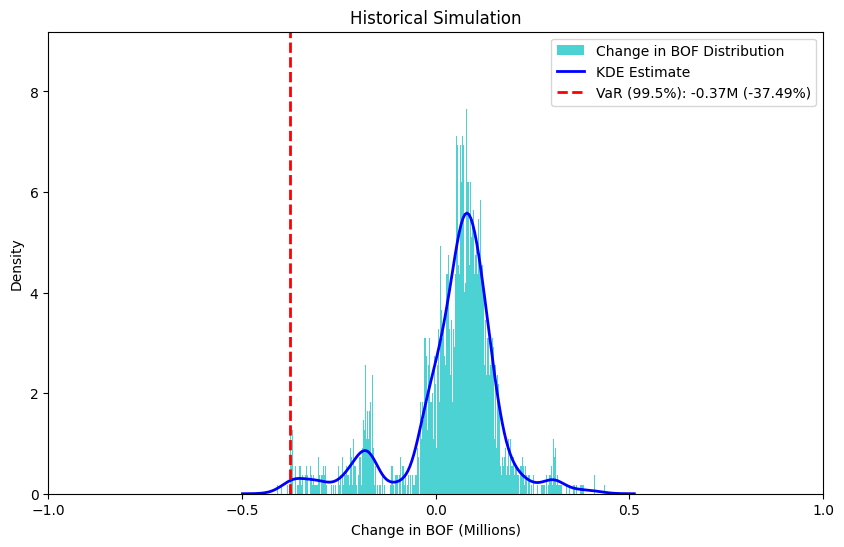

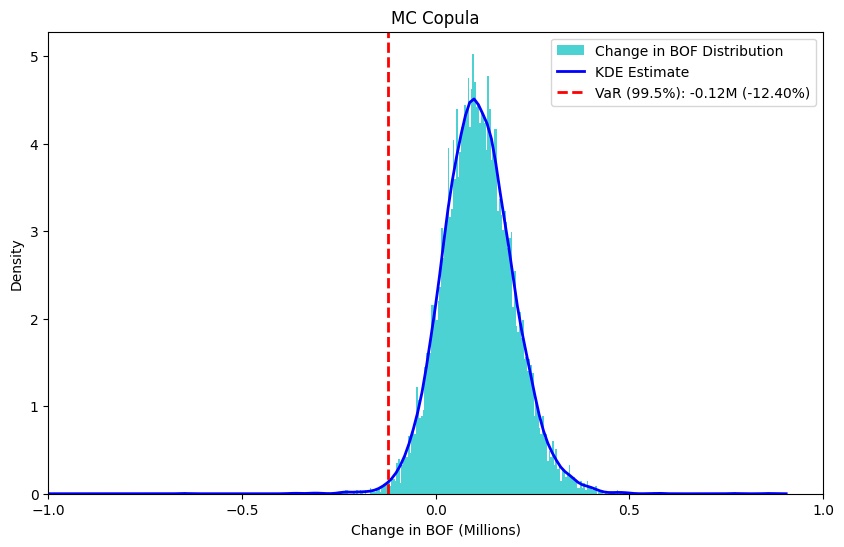

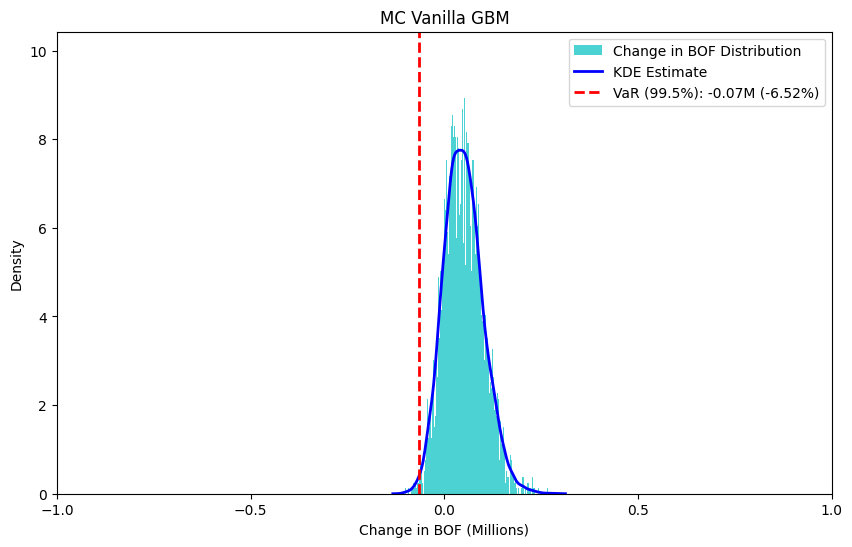

In [8]:
results = load_results()
for model_name, result in results.items():
    plot_bof_var(result['distribution'], result['scr'], model_name, bof_0),

## Internal Models using Neural Networks - GANs

Relevant plots:
- Generated distributions for each asset class, with statistics
- PCA plot
- Tests relevant to GANs
    - Mode Collaps
    - Variance
    - Wasserstein distance plot

A GAN is trained on each asset class, creating generated distribution for 1 year ahead. These distributions are then aggregated using Copulas.

In [9]:
from internal_models.GANs.tuned_GANS.astrid_GAN import AstridGAN
from internal_models.GANs.tuned_GANS.willow_GAN import WillowGAN

## Training the GANs if spesified, otherwise the already generated returns will be used

In [10]:
train_gans = False

In [11]:
if train_gans:
    for asset_name in tqdm(returns_df.columns, desc="Training GANs", unit="asset"):
        print(f"Training GAN for {asset_name}...")
        asset_returns = returns_df[asset_name]

        if asset_name == 'EONIA':
            gan = WillowGAN(asset_returns, asset_name)
        else:
            gan = AstridGAN(asset_returns, asset_name)
        
        gan.train()
        
        print(f"Finished training GAN for {asset_name}.\n")

        gan.generate_scenarios(num_scenarios=num_simulations)

        print(f"Finished generating scenarios GAN {asset_name}.\n")

Presenting GAN results

In [12]:
#extensive_plotting(scaled=False, returns_df=returns_df)

## Add a Preliminary backtesting for each individual GAN

This is meant as a preliminary backtesting for each asset created by individual GANs. Backtesting is done on returns, not BOF (yet).

1. Backtesting plots will be presented
2. Statistical tests will be made
3. Accuracy/adaquecy tests will be made

In [13]:
from utilities.backtesting_plots import backtest_var_single_asset
from utilities.gan_plotting import load_generated_returns
from backtesting.perform_var_tests import perform_var_backtesting_tests
from backtesting.perform_distribution_tests import perform_distribution_tests
from utilities.gan_plotting import create_rolling_empirical

'''
for asset_name in returns_df.columns:
    generated_returns = load_generated_returns(asset_name)
    failures = backtest_var_single_asset(test_returns_df[asset_name], generated_returns, asset_name)
    perform_var_backtesting_tests(failures=failures, returns=test_returns_df[asset_name], var_forecast=None, asset_name=asset_name, generated_returns=generated_returns)
    perform_distribution_tests(generated_returns=generated_returns, empirical_returns_rolling=create_rolling_empirical(returns_df[asset_name]), asset_name = asset_name)
'''

'\nfor asset_name in returns_df.columns:\n    generated_returns = load_generated_returns(asset_name)\n    failures = backtest_var_single_asset(test_returns_df[asset_name], generated_returns, asset_name)\n    perform_var_backtesting_tests(failures=failures, returns=test_returns_df[asset_name], var_forecast=None, asset_name=asset_name, generated_returns=generated_returns)\n    perform_distribution_tests(generated_returns=generated_returns, empirical_returns_rolling=create_rolling_empirical(returns_df[asset_name]), asset_name = asset_name)\n'

## Aggregating the GAN distributions together - Copulas

When aggregated we display the BOF distribtion, as well as the SCR.

Create a Student t copula


Visualize results


In [14]:
# Collecting them toghether

## Exploring a Conditional GAN
 - By adding marketviews through the condition, we might be able to pass the tests..

## Adding Standard Formula

Potential issues: Is the standard formula time dependent.

In [17]:
from standard_formula.sf import calculate_market_scr
from utilities.map_weights_to_assets import map_weights_to_assets

asset_values = map_weights_to_assets(returns_df, weights)

durations = {
    'gov_bonds': 7.29,
    'IG_corp_bonds': 5.90,
    'HY_corp_bonds': 3.14
}

sf_scr = calculate_market_scr(asset_values, durations)
for key, value in sf_scr.items():
    print(f"{key}: {value:,.3f}")

sf_market_scr = -sf_scr['Total Market SCR'] * assets_0


Market SCR Interest: 0.082
Market SCR Equity: 0.118
Market SCR Real Estate: 0.036
Market SCR Spread: 0.045
Total Market SCR: 0.237


## Performing Backtesting

On 1-year out of sample data, the start of the testing period is defined as START_TEST_DATE inside .env.


In [19]:
# Make verbose if you want to visualize more

from backtesting.run_all_tests_on_models import run_all_tests_on_models

benchmark = load_results()
models = {model_name: data["distribution"] for model_name, data in benchmark.items()}

models['Standard Formula'] = sf_market_scr

run_all_tests_on_models(models, test_returns_df, weights, assets_0, liabilities_0, verbose=False)

model_name,LR_pof,p_value_pof,result_pof,LR_ind,p_value_ind,result_ind,LR_joint,p_value_joint,result_joint,avg_lopez_loss
Historical Simulation,2.526321,0.111961,✅ Passed (p > 0.1) - No significant failure pattern detected 🎉,-0.000000,1.000000,✅ Passed (p > 0.1) - No clustering of VaR breaches 🎉,2.526321,0.282759,✅ Passed (p > 0.1) - Joint test does not reject model adequacy 🎉,0.000000
MC Copula,2.526321,0.111961,✅ Passed (p > 0.1) - No significant failure pattern detected 🎉,-0.000000,1.000000,✅ Passed (p > 0.1) - No clustering of VaR breaches 🎉,2.526321,0.282759,✅ Passed (p > 0.1) - Joint test does not reject model adequacy 🎉,0.000000
MC Vanilla GBM,1.737106,0.187506,✅ Passed (p > 0.1) - No significant failure pattern detected 🎉,32.500947,0.000000,❌ Failed (p < 0.1) - VaR breaches are clustered ⚠️,34.238053,0.000000,❌ Failed (p < 0.1) - Joint test indicates model misspecification ⚠️,0.012319
Standard Formula,2.526321,0.111961,✅ Passed (p > 0.1) - No significant failure pattern detected 🎉,-0.000000,1.000000,✅ Passed (p > 0.1) - No clustering of VaR breaches 🎉,2.526321,0.282759,✅ Passed (p > 0.1) - Joint test does not reject model adequacy 🎉,0.000000
